In [1]:
import numpy as np
from scipy.stats import multivariate_normal

class EM:
    def __init__(self,X,clusters=2,init_cov_size=120):
        self.X = X
        self.clusters = clusters
        datapoints = self.X.shape[0]
        dims = self.X.shape[1]
        self.it = 0
        self.init_cov_size = init_cov_size
        
        # initialize with random points and identitiy matrices
        # self.cluster_centers = np.random.uniform(low=self.X.min(axis=0),
        #                                          high=self.X.max(axis=0),
        #                                          size=(self.clusters,self.X.shape[1]))
         
        # init means with random points from the data; seems to result in fewer singulartities
        rand = np.random.choice(datapoints, self.clusters,replace=False)
        self.cluster_centers = self.X[rand,:]
        
        self.cluster_covs = np.stack([np.eye(dims)*self.init_cov_size]*self.clusters,axis=0)
        self.mixing_coeffs = np.full(self.clusters,1/self.clusters)
        
    def fit(self,iterations=10):
        for i in range(iterations):  
            # Expectation
            self.responsibilities = self._expectation(self.X)
            # Maximization
            self._maximization()
            self.it += 1
        return self.cluster_centers, self.cluster_covs
    
    def _expectation(self,X):
        tripel = zip(self.cluster_centers,self.cluster_covs,self.mixing_coeffs)
        responsibilities = np.zeros((self.clusters,X.shape[0]))
        divisor_sum = np.zeros((X.shape[0]))
        
        for i,(mean,cov,mixing_coeff) in enumerate(tripel):
            resp = mixing_coeff * multivariate_normal.pdf(X,mean,cov,allow_singular=True)
            responsibilities[i] = resp
            divisor_sum += resp
        responsibilities /= divisor_sum
        return responsibilities

    
    def _maximization(self):
        X = self.X
        for i,resp in enumerate(self.responsibilities):
            Nk = resp.sum()
            if Nk <= 1:
                # catch near singularities
                print("Singularity detected")
                
                
                # choosing new mean uniformly random
                # new_mean = np.random.uniform(low=self.X.min(axis=0),
                #                              high=self.X.max(axis=0))
                
                # choosing random points form X as mean
                rand = np.random.choice(datapoints, self.clusters,replace=False)
                new_mean = X[rand,:]
                
                new_cov = np.eye(self.X.shape[1]) * self.init_cov_size
            else:
                new_mean = 1/Nk * (resp[:,np.newaxis]*X).sum(axis=0)
                unweighted_product = np.einsum('ji,jk->jik', (X-new_mean), (X-new_mean))
                cov_sum = (resp[:,np.newaxis,np.newaxis]*unweighted_product).sum(axis=0)
                new_cov = 1/Nk * cov_sum
            new_mixing_coeff = Nk/X.shape[0]
            
            self.cluster_centers[i] = new_mean
            self.cluster_covs[i] = new_cov
            self.mixing_coeffs[i] = new_mixing_coeff
                
    def predict(self,X):
        resp = self._expectation(X)
        cluster_prediction = resp.argmax(axis=0)
        prediction = np.copy(X)
        for i,mean in enumerate(self.cluster_centers):
            prediction[cluster_prediction==i] = mean
        return prediction
           

## Plotting utils

In [2]:
from numpy import pi, sin, cos
import matplotlib.pyplot as plt
%matplotlib inline

def oval(cov, num_points=100,radius=1):
    arcs = np.linspace(0, 2 * pi, num_points)
    x = radius * sin(arcs)
    y = radius * cos(arcs)
    
    xy = np.array(list(zip(x, y)))
    x, y = zip(*xy.dot(cov))
    return x,y

def make_plot(a):
    plt.figure(figsize=(6, 5))
    plt.title("EM iteration {}".format(a.it))

    colors = ['g', 'r', 'c', 'm', 'y', 'b' ]
    
    # selcect elements based on expectation
    x, y = zip(*X)
    try:
        plt.scatter(x, y, edgecolors="black",c=a.responsibilities[0],cmap='RdYlGn')
    except AttributeError:
        plt.scatter(x, y, edgecolors="black",color='y')
    for i in range(a.cluster_centers.shape[0]):
        # plot centers
        plt.scatter(a.cluster_centers[i,0],a.cluster_centers[i,1],s=250,color=colors[i],edgecolors="white")

        # plot ovals that show the shape of the  variances
        x, y = oval(a.cluster_covs[i],radius=2)
        x += a.cluster_centers[i,0]
        y += a.cluster_centers[i,1]
        plt.plot(x, y,linewidth=5,color=colors[i])

## Example 1: Simple 2d Dataset

In [3]:
import pandas as pd

# import dataset
X = pd.read_csv("data/2d-em.csv", header=None).as_matrix()
# plot dataset
x, y = zip(*X)
plt.figure(figsize=(6, 5))
plt.scatter(x, y, edgecolors="black")

AttributeError: 'DataFrame' object has no attribute 'as_matrix'

In [4]:
a = EM(X,2,init_cov_size=2)
for i in [1,1,1,2,5,10,10]:
    make_plot(a)
    mm = a.fit(i)

NameError: name 'X' is not defined

## Example 2: image compression

RGB Images nothing more than a large 2d matrix of pixels. Each Pixel takes three values between 0 and 255, corresponding to the intensity of the red, green, or blue colour channels. So In combination there are 255x255x255 possible different colour values for each pixel, resulting in a need for about 24 bits or 3 bytes per pixel. However, for most images a lot of pixels share nearly the same colors. Thus, we can use EM to find clusters of those colours that are distinct from each other and have a high occurence. The first image below is the original image. The second image is the compressed version, where we fit a gaussian mixture with 64 components/clusters w.r.t. the colours of the pixels in the original picture. To store the compressed picture one would only need 6 bits to represent the 64 diffentent compressed colours, resulting in a space reduction of ~75%.

In [5]:
import matplotlib.image as mpimg

def show_img(img):
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.show()

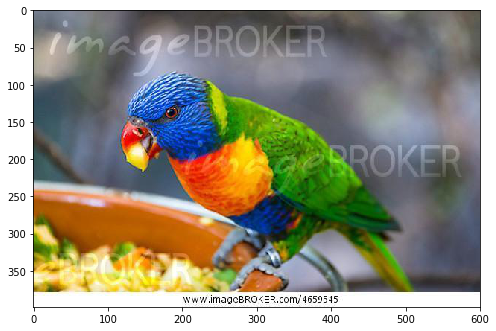

In [6]:
path = './imgs/testBird.jpg'
img = mpimg.imread(path)
show_img(img.astype('uint8'))

In [7]:
rows = img.shape[0]
cols = img.shape[1]

flat_img = img.reshape(img.shape[0] * img.shape[1], 3).astype(np.float)
cmpr = EM(flat_img,64,init_cov_size=30)

In [8]:
a = cmpr.fit(20)

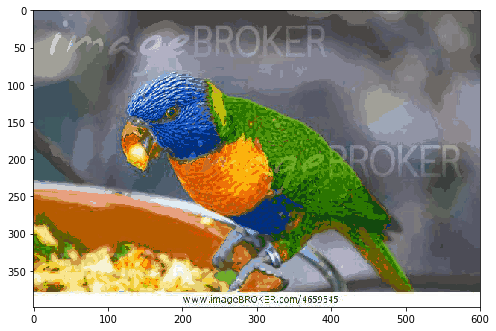

In [9]:
cmpr_img = (cmpr.predict(flat_img)).astype('uint8').reshape(rows,cols, 3)
show_img(cmpr_img)

# Sources:
    - Bishop - Pattern Recognition And Machine Learning - Springer  2006 - Chapter 9.2
    - The Matrix Cookbook: http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf
    - https://math.stackexchange.com/questions/195911/covariance-of-gaussian-mixtures